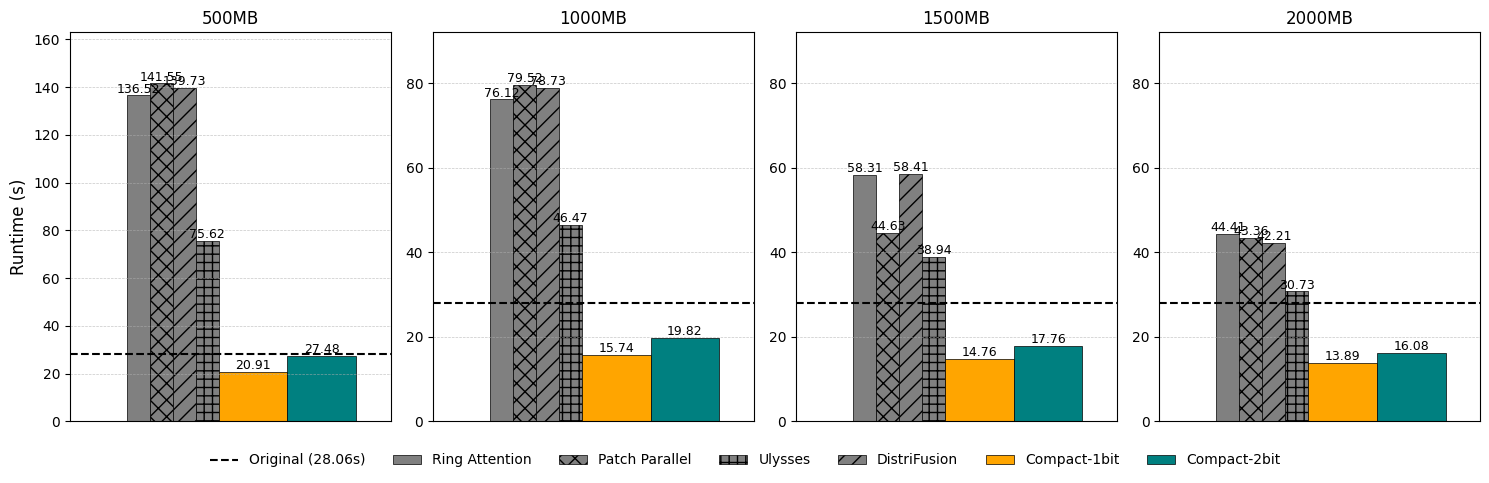

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math

LATENCY_DATA_PATH = 'latency_data/latency_eth.csv'

# Define bandwidths and initial methods (including Original for baseline)
bandwidths = ['500MB', '1000MB', '1500MB', '2000MB']
all_methods_for_data = [
    'Original',
    'Ring Attention',
    'Patch Parallel',
    'Ulysses',
    'DistriFusion',
    'PipeFusion', # Will be removed later
    'Compact-1bit',
    'Compact-2bit',
]
# Define styles, excluding PipeFusion as it won't be plotted
method_styles = {
    # 'Original' is not plotted as bars, only as baseline
    'Ring Attention':{'color': 'gray',      'hatch': None},
    'Compact-1bit':  {'color': 'orange',    'hatch': ''},
    'Compact-2bit':  {'color': 'teal',      'hatch': ''},
    'DistriFusion':  {'color': 'gray',      'hatch': '//'},
    'Patch Parallel':{'color': 'gray',      'hatch': 'xx'},
    'Ulysses':       {'color': 'gray',      'hatch': '++'},
    # 'PipeFusion' style removed as it's excluded
}

# Load data using pandas
data_df = pd.read_csv(LATENCY_DATA_PATH, index_col=0)
# Reindex to ensure correct order and include all necessary methods for data access
data_df = data_df.reindex(index=all_methods_for_data, columns=bandwidths)

# Filter methods to plot (exclude Original bars and PipeFusion)
methods_to_plot = [m for m in all_methods_for_data if m not in ['Original', 'PipeFusion']]
num_methods_to_plot = len(methods_to_plot)

# Define method groups for visual separation
group1_methods = ['Ring Attention', 'Patch Parallel', 'DistriFusion', 'Ulysses'] # Baselines
group2_methods = ['Compact-1bit', 'Compact-2bit'] # Compact methods

# Define bar widths
thin_width = 0.2
wide_width = 0.6
group_gap = 0 # Gap between the two groups (Set to 0 to remove the gap)

# Calculate x-positions for bars to group them visually
method_x_pos = {}
current_pos = 0
# Group 1 positions (thin bars)
for i, method in enumerate(group1_methods):
    method_x_pos[method] = current_pos + thin_width / 2
    current_pos += thin_width
# Add gap (now 0)
current_pos += group_gap
# Group 2 positions (wide bars)
for i, method in enumerate(group2_methods):
    method_x_pos[method] = current_pos + wide_width / 2
    current_pos += wide_width

# Ensure methods_to_plot maintains the desired order for plotting if needed
# (The current order matches group1 then group2)

# Create 4 subplots (1 row, 4 columns), NO shared Y axis
fig, axes = plt.subplots(1, 4, figsize=(15, 5)) # Removed sharey=True

# Calculate max Y for the last three plots (1000MB, 1500MB, 2000MB)
other_bandwidths = ['1000MB', '1500MB', '2000MB']
max_y_others = 0
if len(other_bandwidths) > 0:
     max_y_others = max(data_df.loc[methods_to_plot, other_bandwidths].max().max(),
                        data_df.loc['Original', other_bandwidths].max())
ylim_others = math.ceil(max_y_others * 1.15) # Add 15% padding and round up

# Plot data for each bandwidth in its own subplot
for i, bandwidth in enumerate(bandwidths):
    ax = axes[i]

    # Get the baseline latency for this bandwidth
    original_latency_bw = data_df.loc['Original', bandwidth]

    # Draw the horizontal baseline reference line
    # Label only the first occurrence for the legend
    baseline_label = f'Original ({original_latency_bw:.2f}s)' if i == 0 else None
    ax.axhline(original_latency_bw, color='black', linestyle='--', linewidth=1.5, label=baseline_label)

    # Get latency data for the methods to plot for this bandwidth
    latencies_bw = data_df.loc[methods_to_plot, bandwidth]

    # Plot bars for each method
    max_y_current_plot = original_latency_bw # Start with baseline
    for method in methods_to_plot: # Iterate using the defined order
        latency = latencies_bw[method]
        style = method_styles[method]
        # Determine width based on method group
        width = thin_width if method in group1_methods else wide_width
        x_pos = method_x_pos[method] # Get pre-calculated x-position

        # Label only the first occurrence of each method for the legend
        bar_label = method if i == 0 else None

        # Plot the bar using the calculated x-position
        bar = ax.bar(x_pos, latency, width, label=bar_label,
                     color=style['color'], hatch=style['hatch'], edgecolor='black', linewidth=0.5)

        # Add the latency value annotation on top of the bar
        ax.text(bar[0].get_x() + bar[0].get_width() / 2, latency, f"{latency:.2f}",
                ha='center', va='bottom', fontsize=9, color='black', fontweight='normal') # Adjusted font size/weight

        # Track max y value for this specific plot
        if latency > max_y_current_plot:
            max_y_current_plot = latency

    # --- Configure subplot axes ---
    ax.set_title(f'{bandwidth}', fontsize=12) # Set bandwidth as title
    # Remove x-axis labels and ticks
    ax.set_xticks([])
    ax.tick_params(axis='x', length=0) # Hide tick lines as well

    # Set Y-axis limits
    if i == 0: # Special scaling for 500MB
        ylim_500mb = math.ceil(max_y_current_plot * 1.15) # Add 15% padding and round up
        ax.set_ylim(bottom=0, top=ylim_500mb)
        # Set common Y-axis label only on the first subplot
        ax.set_ylabel('Runtime (s)', fontsize=12)
    else: # Shared scaling for 1000MB, 1500MB, 2000MB
        ax.set_ylim(bottom=0, top=ylim_others)

    # Adjust x-axis limits based on calculated positions and widths
    min_x = min(method_x_pos.values()) - wide_width # Use wide_width for safety margin
    max_x = max(method_x_pos.values()) + wide_width
    ax.set_xlim(min_x, max_x)

    ax.tick_params(axis='y', labelsize=10)
    ax.grid(axis='y', linestyle='--', linewidth=0.5, alpha=0.7)


# Create a single legend for the figure below the subplots
handles, labels = axes[0].get_legend_handles_labels()
# Adjust bbox_to_anchor y-position slightly if needed due to narrower figure
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.02), ncol=len(labels), fontsize=10, frameon=False)

# Adjust layout to prevent labels/legend from overlapping and make space
plt.tight_layout(rect=[0, 0.05, 1, 0.95]) # Adjust rect to accommodate legend and suptitle

plt.show()
